In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fredapi as fa
from scipy import stats
import numpy as np
sns.set()

In [2]:
assets = ['MSFT', 'AAPL', 'AMZN', 'TSLA', 'GOOGL'] # Assets for portfolio

# Load asset prices
asset_prices = pd.read_csv(r"C:\Users\DELL\OneDrive\Desktop\M.Sc.(WQU)\C2_Financial_Data\M3_Portfolios_and_tick_data\L2\portfolio_prices_L2.csv", index_col = "Date", parse_dates = True)

# Load risk-free rate data (3-month Treasury bill)
risk_free = pd.read_csv(r"C:\Users\DELL\OneDrive\Desktop\M.Sc.(WQU)\C2_Financial_Data\M3_Portfolios_and_tick_data\L2\risk_free_L2.csv", index_col = "Date", parse_dates = True)

r = asset_prices.pct_change().dropna() # Calculating daily percent returns

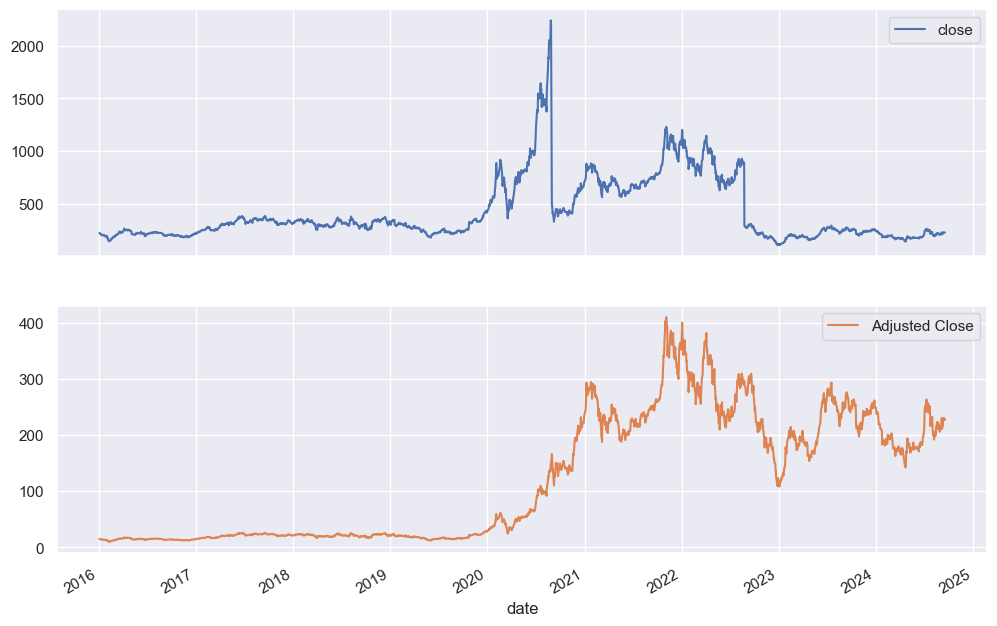

In [3]:
#1. Total Returns and Dividend-Adjusted Returns

# Figure 1
tsla = pd.read_csv(r"C:\Users\DELL\OneDrive\Desktop\M.Sc.(WQU)\C2_Financial_Data\M3_Portfolios_and_tick_data\L2\TSLA_stock_price_L2.csv")
tsla.set_index('date', inplace=True)
tsla.index = pd.to_datetime(tsla.index)

splits = {'2022-08-25' : 3, "2020-08-31" : 5} # The dates and multiplier of TSLA splits

tsla['Adjusted Close'] = tsla['close'].copy()

for date, split in splits.items():
    date = pd.to_datetime(date) - pd.Timedelta(days=1)
    tsla.loc[:date, 'Adjusted Close'] = tsla.loc[:date, 'Adjusted Close'] / split

tsla[['close', 'Adjusted Close']].loc["2016":].plot(figsize=(12, 8), subplots = True)
plt.show()


In [4]:
'''Exercise 1
Compute the daily returns (percent or log) of the close and adjusted-close price of TSLA. Are they different?'''

import yfinance as yf
import pandas as pd
import numpy as np

tsla = yf.download(
    "TSLA",
    start="2020-01-01",
    end="2024-01-01",
    auto_adjust=False
)

# Flatten MultiIndex
tsla.columns = tsla.columns.droplevel(1)

print(tsla.columns)


# Percent returns
tsla['ret_close'] = tsla['Close'].pct_change() * 100
tsla['ret_adjclose'] = tsla['Adj Close'].pct_change() * 100

# Log returns
tsla['log_ret_close'] = np.log(tsla['Close'] / tsla['Close'].shift(1))
tsla['log_ret_adjclose'] = np.log(tsla['Adj Close'] / tsla['Adj Close'].shift(1))

# Compare differences
diff = tsla['ret_close'] - tsla['ret_adjclose']

print("Number of days with different returns:",
      diff.abs().gt(1e-6).sum())


[*********************100%***********************]  1 of 1 completed

Index(['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')
Number of days with different returns: 0


[*********************100%***********************]  1 of 1 completed


Index(['Adj Close', 'Close', 'Dividends', 'High', 'Low', 'Open',
       'Stock Splits', 'Volume'],
      dtype='object', name='Price')
Index(['Close', 'Dividends', 'Stock Splits'], dtype='object', name='Price')


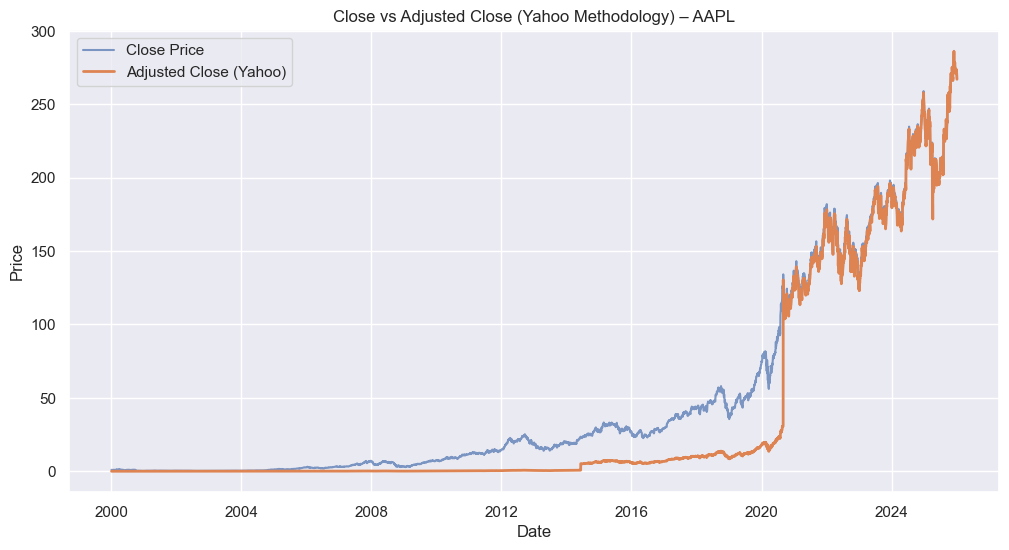

In [11]:
'''Exercise 2
Create an account in AlphaVantage and obtain an APIKEY. Select an asset that had undergone several splits (2 or more) and 
paid some dividends (twice or more) and download the close price (not adjusted). Use the Yahoo methodology, found in the 
link provided above, in order to calculate the adjusted-close price. Plot the results as in Figure 1.'''
#Your API key is: VZ7D9OXSZLI6R05R

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

symbol = "AAPL"

df = yf.download(
    symbol,
    start="2000-01-01",
    auto_adjust=False,
    actions=True
)

# Flatten columns
df.columns = df.columns.droplevel(1)

print(df.columns)
data = df[['Close', 'Dividends', 'Stock Splits']].copy()
print(data.columns)

data['adj_factor'] = 1.0
factor = 1.0

for i in range(len(data)-1, -1, -1):
    close = data.iloc[i]['Close']
    div = data.iloc[i]['Dividends']
    split = data.iloc[i]['Stock Splits']

    if split == 0:
        split = 1

    factor *= (1 - div / close) / split
    data.iloc[i, data.columns.get_loc('adj_factor')] = factor

data['Adj_Close_Yahoo'] = data['Close'] * data['adj_factor']

#plot
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Close'], label='Close Price', alpha=0.7)
plt.plot(data.index, data['Adj_Close_Yahoo'], label='Adjusted Close (Yahoo)', linewidth=2)
plt.title("Close vs Adjusted Close (Yahoo Methodology) – AAPL")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


In [12]:
#1.3 Time-Weighted Returns¶

# Calculate equal-weighted portfolio daily returns (the investment strategy)
portfolio_daily_returns = r.loc['2020-01-01':'2020-12-31', assets].mean(axis=1)

# Define cash flow dates and scenarios
dates = pd.to_datetime(['2020-01-02', '2020-03-23', '2020-06-15', '2020-12-31'])
cash_flows_A = [0, 50000, 0, 0]  # Investor A: adds $50k at market bottom (lucky)
cash_flows_B = [0, 0, 50000, 0]  # Investor B: adds $50k after recovery (unlucky)

# Function to calculate portfolio values given cash flows
def calculate_portfolio_values(initial_value, cash_flows, returns, dates):
    """
    Calculate portfolio values using end-of-period cash flow convention.
    
    Parameters:
    - initial_value: portfolio value at close of dates[0]
    - cash_flows: list of cash flows occurring at end of each period
    - returns: series of daily returns
    - dates: list of dates marking period boundaries
    
    Returns period-end values including cash flows.
    """
    values = [initial_value]
    current_value = initial_value
    
    for i in range(len(dates) - 1):
        start = dates[i]
        end = dates[i+1]
        
        # Apply returns for (start, end] - excludes start, includes end
        period_returns = returns.loc[(returns.index > start) & (returns.index <= end)]
        
        for daily_return in period_returns:
            current_value *= (1 + daily_return)
        
        # Add cash flow at end of period (after all returns for the period)
        current_value += cash_flows[i+1]
        values.append(current_value)
    
    return values

# Calculate portfolio values for both investors
values_A = calculate_portfolio_values(100000, cash_flows_A, portfolio_daily_returns, dates)
values_B = calculate_portfolio_values(100000, cash_flows_B, portfolio_daily_returns, dates)

# Calculate Simple Return (naive calculation - wrong for comparison)
simple_return_A = (values_A[-1] - values_A[0] - sum(cash_flows_A)) / values_A[0]
simple_return_B = (values_B[-1] - values_B[0] - sum(cash_flows_B)) / values_B[0]

# Calculate Time-Weighted Return (correct for manager performance)
def calculate_twr(values, cash_flows):
    """Calculate TWR using end-of-period cash flow convention."""
    sub_period_returns = []
    for i in range(len(values) - 1):
        # Sub-period return: (end_value - start_value - cash_flow) / start_value
        r_i = (values[i+1] - values[i] - cash_flows[i+1]) / values[i]
        sub_period_returns.append(r_i)
    twr = np.prod([1 + r for r in sub_period_returns]) - 1
    return twr

twr_A = calculate_twr(values_A, cash_flows_A)
twr_B = calculate_twr(values_B, cash_flows_B)

# Display comparison
results = pd.DataFrame({
    'Investor A (Deposit at Bottom)': [f'{simple_return_A:.2%}', f'{twr_A:.2%}'],
    'Investor B (Deposit After Recovery)': [f'{simple_return_B:.2%}', f'{twr_B:.2%}'],
    'Difference': [f'{abs(simple_return_A - simple_return_B):.2%}', 
                   f'{abs(twr_A - twr_B):.4%}']
}, index=['Simple Return', 'Time-Weighted Return'])

results

,Investor A (Deposit at Bottom),Investor B (Deposit After Recovery),Difference
Simple Return,205.32%,159.11%,46.21%
Time-Weighted Return,127.32%,127.32%,0.0000%


In [13]:
'''Exercise 3

You manage a portfolio that starts with $200,000 on January 1, 2021. Using the equal-weighted portfolio of our five assets (MSFT, AAPL, AMZN, TSLA, GOOGL), 
calculate the following:

a) On April 1, 2021, your client withdraws $30,000. On September 1, 2021, they deposit $50,000. 
Calculate the portfolio values at these dates and at year-end (December 31, 2021).

b) Calculate the Time-Weighted Return for the entire year using the end-of-period cash flow convention.

c) Calculate the "simple return" as: (Ending Value - Starting Value - Net Cash Flows) / Starting Value.

d) Explain why these two returns differ and which one correctly measures your skill as a portfolio manager.

e) If your compensation is based on performance, which metric should be used? Why?'''

#download data
import yfinance as yf
import pandas as pd
import numpy as np

assets = ["MSFT", "AAPL", "AMZN", "TSLA", "GOOGL"]

prices = yf.download(
    assets,
    start="2021-01-01",
    end="2022-01-01",
    auto_adjust=True
)["Close"]

# Daily returns
returns = prices.pct_change().dropna()

# Equal-weighted portfolio returns
weights = np.repeat(1/5, 5)
portfolio_returns = returns.dot(weights)

#Compute Portfolio Value with Cash Flows
initial_value = 200_000

# Create portfolio value series
portfolio_value = (1 + portfolio_returns).cumprod() * initial_value

# Cash flows
portfolio_value.loc["2021-04-01":] -= 30_000
portfolio_value.loc["2021-09-01":] += 50_000

# Key dates
value_apr1 = portfolio_value.loc["2021-04-01"]
value_sep1 = portfolio_value.loc["2021-09-01"]
value_end = portfolio_value.iloc[-1]

value_apr1, value_sep1, value_end

#convention
# Sub-periods
V0 = initial_value
V1 = portfolio_value.loc["2021-04-01"] + 30_000   # add back withdrawal
V2 = portfolio_value.loc["2021-09-01"] - 50_000   # remove deposit
V3 = portfolio_value.iloc[-1]

R1 = (V1 - V0) / V0
R2 = (V2 - V1) / V1
R3 = (V3 - V2) / V2

TWR = (1 + R1) * (1 + R2) * (1 + R3) - 1
TWR

net_cash_flow = 50_000 - 30_000  # +20,000

simple_return = (value_end - initial_value - net_cash_flow) / initial_value
simple_return





[*********************100%***********************]  5 of 5 completed


np.float64(0.44085510373342374)

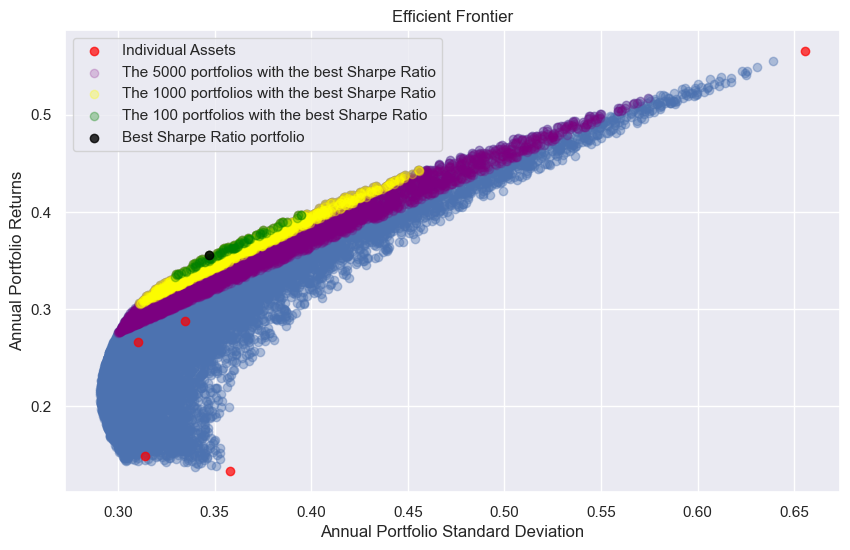

In [14]:
#3. Portfolio Sharpe Ratio and the Efficient Frontier

# Figure 2
weights = np.random.dirichlet(np.ones(5)*0.7, size = 20000) # Creating 20000 sets of weights using dirichlet distribution

assert np.isclose(np.sum(weights, axis = 1), 1).all() # Check that each set of weights sum up to 1

eff_front_dict = {}
cov_matrix_ret = r.cov() * 252
expected_returns = r.mean() * 252
risk_free_rate = risk_free['^IRX'].mean() / 100 # The rates are already annualized

# Filling the eff_front_dict
for w in weights:
  port_ret = expected_returns @ w.T # Annualized percent returns as expected returns
  port_std = np.sqrt(w.T @ cov_matrix_ret @ w)
  sharpe_ratio = (port_ret - risk_free_rate) / port_std
  eff_front_dict[str(list(w))] = [port_ret, port_std, sharpe_ratio]

eff_frontier_dataframe = pd.DataFrame(eff_front_dict, index = ['Returns', 'Standard Deviation', 'Sharpe Ratio']).T # Storing everything in one dataframe
highest_sharpe_ratio = eff_frontier_dataframe.sort_values(by = 'Sharpe Ratio', ascending = False) # Sorting the portfolios with respect to Sharpe Ratio

# Plot the portfolio returns vs portfolio variance
plt.figure(figsize = (10,6))
plt.scatter(x = eff_frontier_dataframe['Standard Deviation'], y = eff_frontier_dataframe['Returns'], alpha = 0.4)
plt.scatter(x = r.std() * np.sqrt(252), y = expected_returns, color = 'red', label = "Individual Assets", alpha = 0.7)
plt.scatter(x = highest_sharpe_ratio[:5000]['Standard Deviation'], y = highest_sharpe_ratio[:5000]['Returns'], color = 'purple', alpha = 0.2, label = "The 5000 portfolios with the best Sharpe Ratio" )
plt.scatter(x = highest_sharpe_ratio[:1000]['Standard Deviation'], y = highest_sharpe_ratio[:1000]['Returns'], color = 'yellow', alpha = 0.3, label = "The 1000 portfolios with the best Sharpe Ratio" )
plt.scatter(x = highest_sharpe_ratio[:100]['Standard Deviation'], y = highest_sharpe_ratio[:100]['Returns'], color = 'green', alpha = 0.3, label = "The 100 portfolios with the best Sharpe Ratio" )
plt.scatter(x = highest_sharpe_ratio.iloc[0,:]['Standard Deviation'], y = highest_sharpe_ratio.iloc[0,:]['Returns'], color = 'black', alpha = 0.8, label = "Best Sharpe Ratio portfolio" )

plt.title("Efficient Frontier")
plt.xlabel("Annual Portfolio Standard Deviation")
plt.ylabel("Annual Portfolio Returns")
plt.legend()
plt.show()

In [ ]:
'''Exercise 4
Explain why we expect that the best Sharpe ratio portfolio will be on the efficient frontier.'''




In [ ]:
'''Exercise 5 (for discussion)

Use the highest_sharpe_ratio dataframe and print the 10 portfolios with the highest Sharpe ratio. If you look at the weights closely, 
you will observe that while the Sharpe ratios between these portfolios are very similar, the weights vary a lot. For example, 
the weight for the 1st asset in the 8th portfolio is 44.8%, but the weight for the same asset in the 7th portfolio is 18.7%. 
However, the difference in their Sharpe ratios is minimal. Think it over and then discuss with your peers in the forum the implications 
of the above observation on portfolio management: that several very different portfolios have almost identical Sharpe ratios.'''


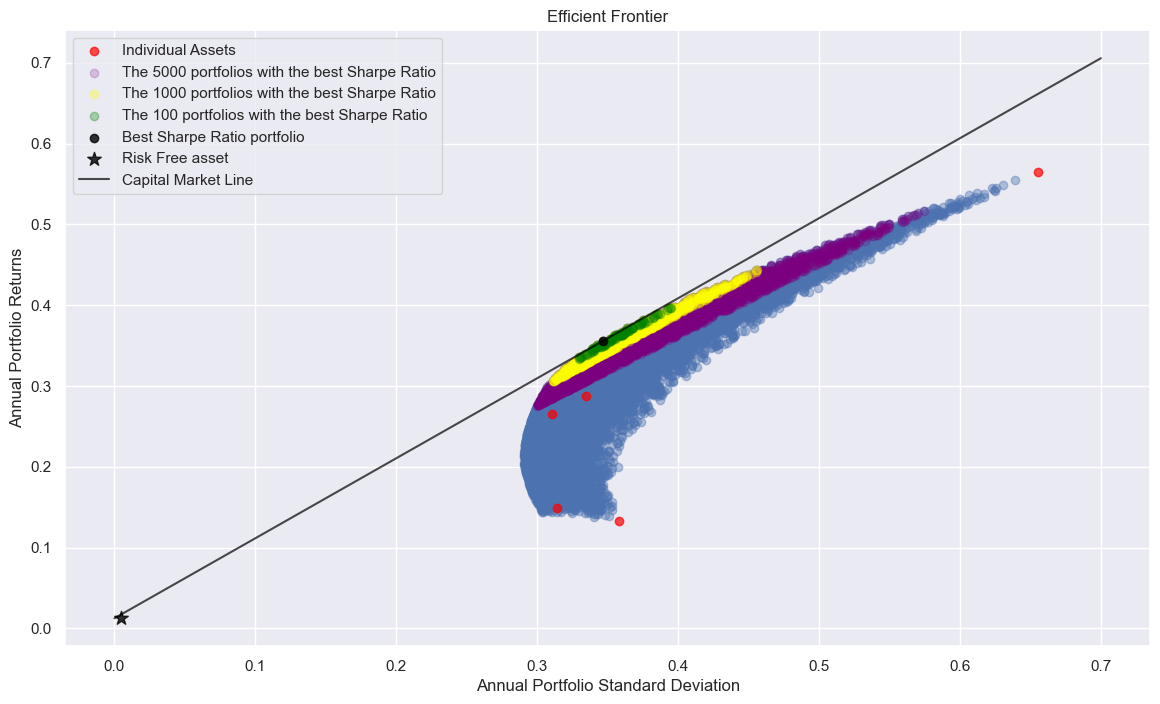

In [15]:
#4. The Tangency Portfolio and the Tangent Line

sigmas = np.linspace(0,0.7, 100)
CML = risk_free_rate + highest_sharpe_ratio['Sharpe Ratio'].iloc[0] * sigmas # This is the Capital Market Line

# Plot the portfolio returns vs portfolio variance
plt.figure(figsize = (14,8))
plt.scatter(x = eff_frontier_dataframe['Standard Deviation'], y = eff_frontier_dataframe['Returns'], alpha = 0.4)
plt.scatter(x = r.std() * np.sqrt(252), y = expected_returns, color = 'red', label = "Individual Assets", alpha = 0.7)
plt.scatter(x = highest_sharpe_ratio[:5000]['Standard Deviation'], y = highest_sharpe_ratio[:5000]['Returns'], color = 'purple', alpha = 0.2, label = "The 5000 portfolios with the best Sharpe Ratio" )
plt.scatter(x = highest_sharpe_ratio[:1000]['Standard Deviation'], y = highest_sharpe_ratio[:1000]['Returns'], color = 'yellow', alpha = 0.3, label = "The 1000 portfolios with the best Sharpe Ratio" )
plt.scatter(x = highest_sharpe_ratio[:100]['Standard Deviation'], y = highest_sharpe_ratio[:100]['Returns'], color = 'green', alpha = 0.3, label = "The 100 portfolios with the best Sharpe Ratio" )
plt.scatter(x = highest_sharpe_ratio.iloc[0,:]['Standard Deviation'], y = highest_sharpe_ratio.iloc[0,:]['Returns'], color = 'black', alpha = 0.8, label = "Best Sharpe Ratio portfolio" )
plt.scatter(x = (risk_free / 252).std(), y = risk_free_rate, color = 'black', alpha = 0.8, marker = '*', label = "Risk Free asset", s = 105)
plt.plot(sigmas, CML, color = 'black', label = "Capital Market Line", alpha = 0.7)


plt.title("Efficient Frontier")
plt.xlabel("Annual Portfolio Standard Deviation")
plt.ylabel("Annual Portfolio Returns")
plt.legend()
plt.show()


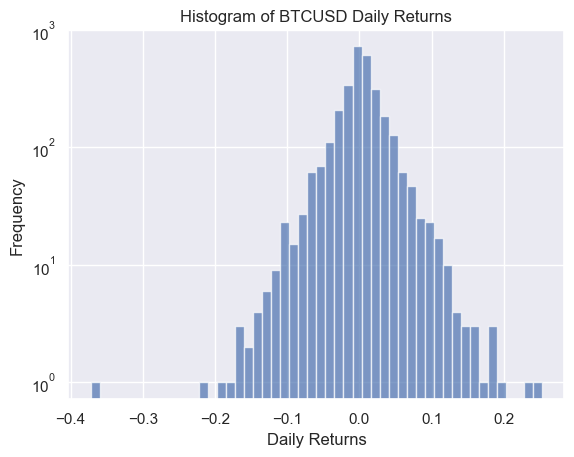

In [17]:
#6.1 Implementing Value at Risk (VaR) - Historical Method

# Figure 1
btcusd = pd.read_csv(r"C:\Users\DELL\OneDrive\Desktop\M.Sc.(WQU)\C2_Financial_Data\M3_Portfolios_and_tick_data\L2\btcusd_L2.csv", index_col = "Date", parse_dates = True)
btcusd_returns = btcusd.pct_change().dropna()

plt.hist(x = btcusd_returns, bins=50, log = True, alpha = 0.7)
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.title('Histogram of BTCUSD Daily Returns')
plt.show()

In [18]:
#next function

def getHistoricalVar(returns, confidenceLevel):
    var = np.quantile(returns, 1 - confidenceLevel)
    print(
        f"The Historical VaR with confidence {confidenceLevel} is {round(100 * var, 3)}% \n"
    )

getHistoricalVar(btcusd_returns, 0.90)
getHistoricalVar(btcusd_returns, 0.95)
getHistoricalVar(btcusd_returns, 0.99)

The Historical VaR with confidence 0.9 is -3.717% 

The Historical VaR with confidence 0.95 is -6.0% 

The Historical VaR with confidence 0.99 is -10.57% 



In [19]:
#6.2 Conditional Value at Risk (CVaR) using Historical Data

def getHistoricalCVar(returns, confidenceLevel):
    var = np.quantile(returns, 1 - confidenceLevel)
    cvar = returns[returns <= var].mean()
    print(
        f"With {confidenceLevel} percent confidence VaR, our Expected Shortfall is {round(100 * cvar, 3)} using historical VaR \n"
    )

getHistoricalCVar(btcusd_returns, 0.90)
getHistoricalCVar(btcusd_returns, 0.95)
getHistoricalCVar(btcusd_returns, 0.99)


With 0.9 percent confidence VaR, our Expected Shortfall is BTC-USD   -6.893
dtype: float64 using historical VaR 

With 0.95 percent confidence VaR, our Expected Shortfall is BTC-USD   -9.017
dtype: float64 using historical VaR 

With 0.99 percent confidence VaR, our Expected Shortfall is BTC-USD   -14.285
dtype: float64 using historical VaR 



In [20]:
#7.2 Implementing Parametric VaR with Normal Distribution

mean = btcusd_returns.mean()
std = btcusd_returns.std()

var_90 = stats.norm.ppf(0.1, mean, std)[0]
var_95 = stats.norm.ppf(0.05, mean, std)[0]
var_99 = stats.norm.ppf(0.01, mean, std)[0]

print(f"The parametric VaR assuming a normal distribution with a 90% confidence interval, is {round(100 * var_90, 3)} \n")
print(f"The parametric VaR assuming a normal distribution with a 95% confidence interval, is {round(100 * var_95, 3)} \n")
print(f"The parametric VaR assuming a normal distribution with a 99% confidence interval, is {round(100 * var_99, 3)} \n")



The parametric VaR assuming a normal distribution with a 90% confidence interval, is -4.716 

The parametric VaR assuming a normal distribution with a 95% confidence interval, is -6.108 

The parametric VaR assuming a normal distribution with a 99% confidence interval, is -8.72 



In [21]:
'''Exercise 6
Calculate the Kurtosis of BTCUSD returns and make sure you understand the effects of high kurtosis on the tails. 
Then argue about the reason the normal distribution seems to underestimate the VaRs in comparison to the historical method.'''

import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import kurtosis

# Download BTC-USD data
btc = yf.download("BTC-USD", start="2018-01-01", auto_adjust=True)

# Compute daily log returns
btc['ret'] = np.log(btc['Close'] / btc['Close'].shift(1))
btc = btc.dropna()

# Kurtosis (Fisher=False gives normal=3)
btc_kurtosis = kurtosis(btc['ret'], fisher=False)

btc_kurtosis



[*********************100%***********************]  1 of 1 completed


np.float64(17.661927500765607)

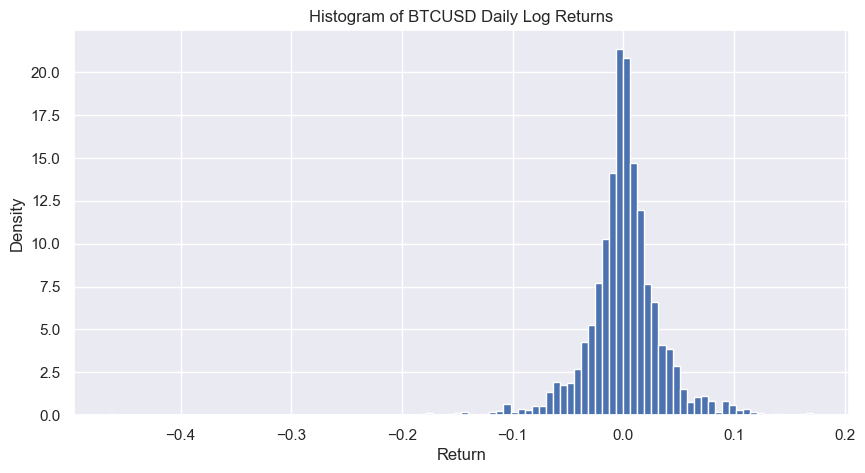

Date
2020-03-12   -0.464730
2018-01-16   -0.184582
2022-06-13   -0.174053
2018-02-05   -0.173982
2022-11-09   -0.154890
2019-06-27   -0.151820
2021-05-19   -0.148107
2018-11-19   -0.143561
2021-05-12   -0.142967
2021-01-21   -0.142528
Name: ret, dtype: float64

In [23]:
'''Exercise 7 (discussion)
Check the BTCUSD histogram presented in Figure 1. Make sure you also print the first 10 returns after you have sorted them 
with ascending = True. Elaborate on the gaps between the returns (as data points) of the left tail: does our sample adequately represent the left tail?'''

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(btc['ret'], bins=100, density=True)
plt.title("Histogram of BTCUSD Daily Log Returns")
plt.xlabel("Return")
plt.ylabel("Density")
plt.show()

#Print the Worst 10 Returns
btc['ret'].sort_values(ascending=True).head(10)

In [24]:
#7.3 Implementing Parametric VaR with t-distribution

# degrees of freedom

def getTVar(returns, dof, confidenceLevel):
    mean = returns.mean()
    std = returns.std()
    var = np.sqrt((dof - 2) / dof) * stats.t.ppf(1 - confidenceLevel, dof) * std + mean
    return (100 * var).round(3)

print(f"The parametric VaR using t-distribution with a confidence interval 0.9, is {getTVar(btcusd_returns, 5, 0.9)}% \n")
print(f"The parametric VaR using t-distribution with a confidence interval 0.95, is {getTVar(btcusd_returns, 5, 0.95)}% \n")
print(f"The parametric VaR using t-distribution with a confidence interval 0.99, is {getTVar(btcusd_returns, 5, 0.99)}% \n")

The parametric VaR using t-distribution with a confidence interval 0.9, is BTC-USD   -4.186
dtype: float64% 

The parametric VaR using t-distribution with a confidence interval 0.95, is BTC-USD   -5.786
dtype: float64% 

The parametric VaR using t-distribution with a confidence interval 0.99, is BTC-USD   -9.793
dtype: float64% 



Value at Risk (VaR) at 95.0% confidence level: -$3,253.02


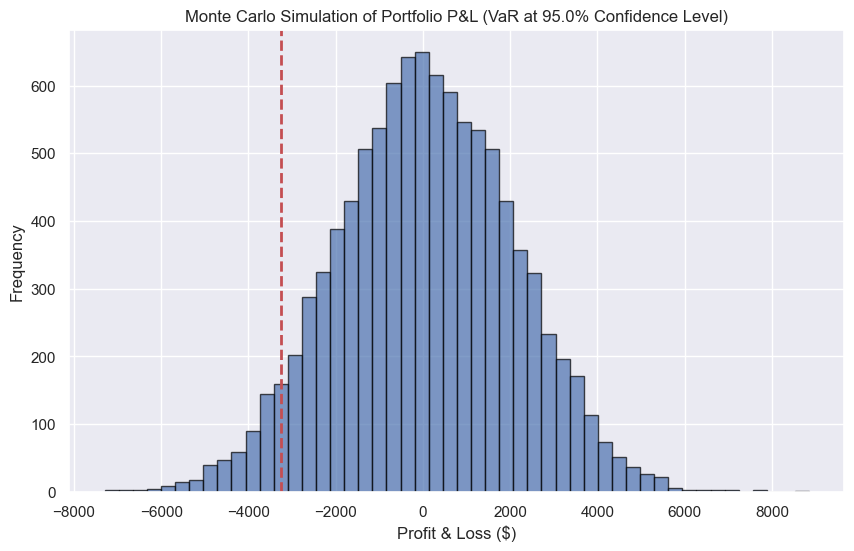

In [25]:
#8. VaR Using Monte Carlo Simulation

# Parameters
initial_investment = 100000  # Initial portfolio value (in dollars)
mean_return = 0.0005  # Daily mean return of the asset (e.g., 0.05%)
volatility = 0.02  # Daily volatility (not annual!) is 2%
days = 1  # 1 day time horizon
num_simulations = 10000  # Number of Monte Carlo simulations
confidence_level = 0.95  # Confidence level for VaR (e.g., 95%)

# Generate random returns based on normal distribution
np.random.seed(2024)  # For reproducibility
random_returns = np.random.normal(loc=mean_return * days, scale=volatility * np.sqrt(days), size=num_simulations)

# Calculate portfolio values at the end of the simulation
portfolio_end_values = initial_investment * (1 + random_returns)

# Calculate profit and loss (P&L)
portfolio_pnl = portfolio_end_values - initial_investment

# Calculate the VaR at the specified confidence level
VaR = np.percentile(portfolio_pnl, (1 - confidence_level) * 100)

# Output the results
print(f"Value at Risk (VaR) at {confidence_level * 100}% confidence level: -${abs(VaR):,.2f}")

#Plot the distribution of portfolio P&L
plt.figure(figsize=(10, 6))
plt.hist(portfolio_pnl, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=VaR, color='r', linestyle='dashed', linewidth=2)
plt.title(f"Monte Carlo Simulation of Portfolio P&L (VaR at {confidence_level * 100}% Confidence Level)")
plt.xlabel('Profit & Loss ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()